In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, SGD
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

Using TensorFlow backend.


# Data Preprocessing

In [2]:
# Set the random seed
random_seed = 135791113

def load_data():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    X_train = x_train.astype('float32')
    X_test = x_test.astype('float32')
    return X_train, y_train, X_test, y_test

def labelencoding(y_train, y_val, y_test, nb_classes):
    Y_val = to_categorical(y_val, num_classes = nb_classes)
    Y_test = to_categorical(y_test, num_classes = nb_classes)
    Y_train = to_categorical(y_train.reshape(-1, 1), num_classes = nb_classes)
    return Y_train, Y_val, Y_test

def split_dataset(X_train, Y_train):

    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state=random_seed)
    
    return X_train, X_val, Y_train, Y_val

In [3]:
CLASSES = 10
X_train, Y_train, X_test, Y_test = load_data()
X_train, X_val, Y_train, Y_val = split_dataset(X_train, Y_train)
Y_train, Y_val, Y_test = labelencoding(Y_train, Y_val, Y_test, CLASSES)

### Normalization

In [4]:
X_train = X_train / 255.

X_val = X_val / 255.

X_test = X_test / 255.

# Model: VGG-like convnet

In [5]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu', name="dense_1"))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax', name="dense_2"))

### Model Compilation

In [6]:
rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss='categorical_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

### Training

In [7]:
checkPoint = ModelCheckpoint("weights/cifar10/weights.{epoch:02d}-{val_acc:.2f}.hdf5",
                             monitor='val_acc',
                             save_weights_only=True)

In [8]:
BATCH_SIZE = 64
EPOCHS = 20
history = model.fit(X_train, Y_train, 
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data = (X_val, Y_val),
                    callbacks=[checkPoint])

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 54s 1ms/step - loss: 1.7510 - acc: 0.3625 - val_loss: 1.3351 - val_acc: 0.5167
Epoch 2/20
40000/40000 [==============================] - 53s 1ms/step - loss: 1.3542 - acc: 0.5157 - val_loss: 1.1585 - val_acc: 0.5801
Epoch 3/20
40000/40000 [==============================] - 51s 1ms/step - loss: 1.1717 - acc: 0.5895 - val_loss: 1.0074 - val_acc: 0.6396
Epoch 4/20
40000/40000 [==============================] - 51s 1ms/step - loss: 1.0603 - acc: 0.6303 - val_loss: 0.9165 - val_acc: 0.6738
Epoch 5/20
40000/40000 [==============================] - 49s 1ms/step - loss: 0.9766 - acc: 0.6590 - val_loss: 0.8904 - val_acc: 0.6833
Epoch 6/20
40000/40000 [==============================] - 49s 1ms/step - loss: 0.9188 - acc: 0.6822 - val_loss: 0.8581 - val_acc: 0.7038
Epoch 7/20
40000/40000 [==============================] - 50s 1ms/step - loss: 0.8786 - acc: 0.6975 - val_loss: 0.7907 - val_acc

## Learning Curves

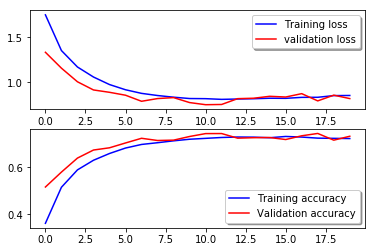

In [9]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
plt.show()

## Predict

In [10]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)

## Metrics

In [11]:
Y_true = np.argmax(Y_test, axis=1)
acc = accuracy_score(Y_true, predictions)

print("Accuracy: {}".format(acc))

Accuracy: 0.736
